In [ ]:
# importing packages

In [572]:
import pyomo.environ as pyo
import numpy as np
from matplotlib import pyplot as plt
import math
import scipy.stats as stats
from scipy.optimize import fsolve, bisect
import pandas as pd

Conductivity of Simple Ionic Mixtures

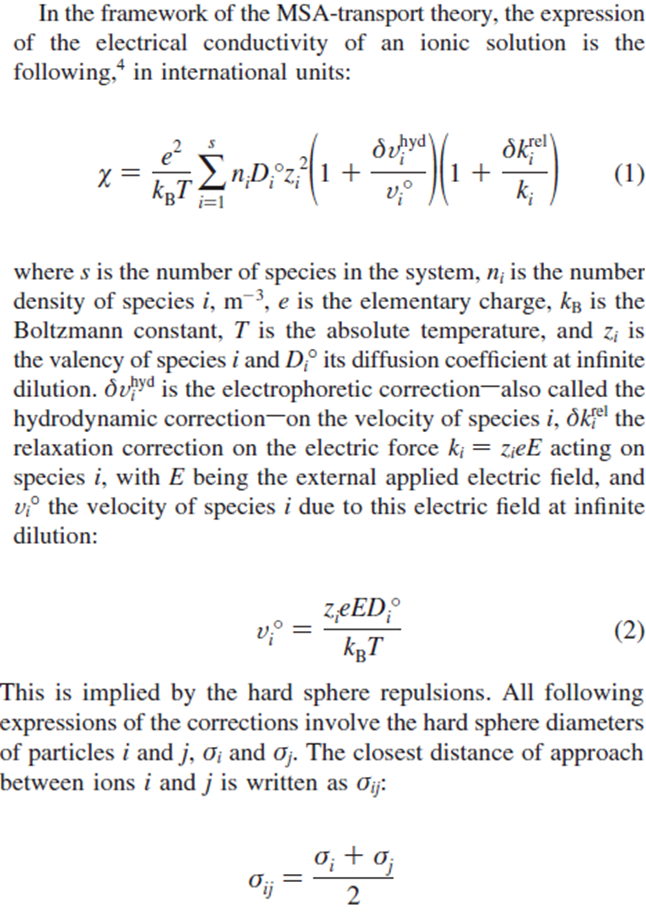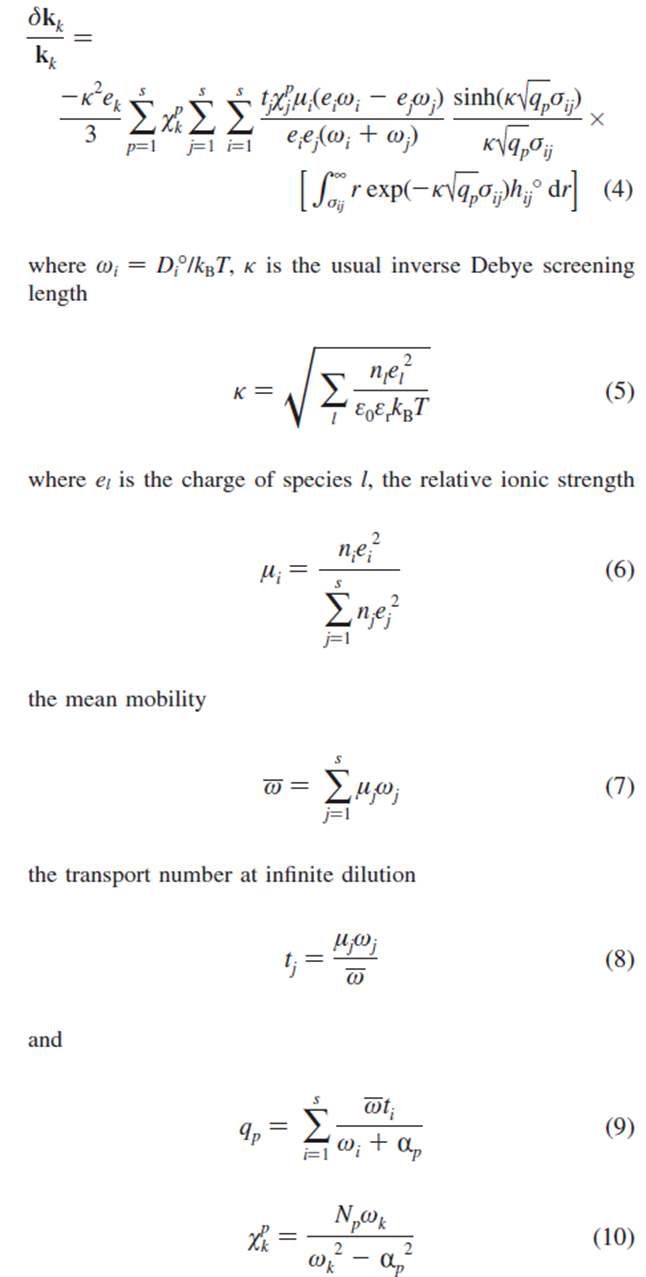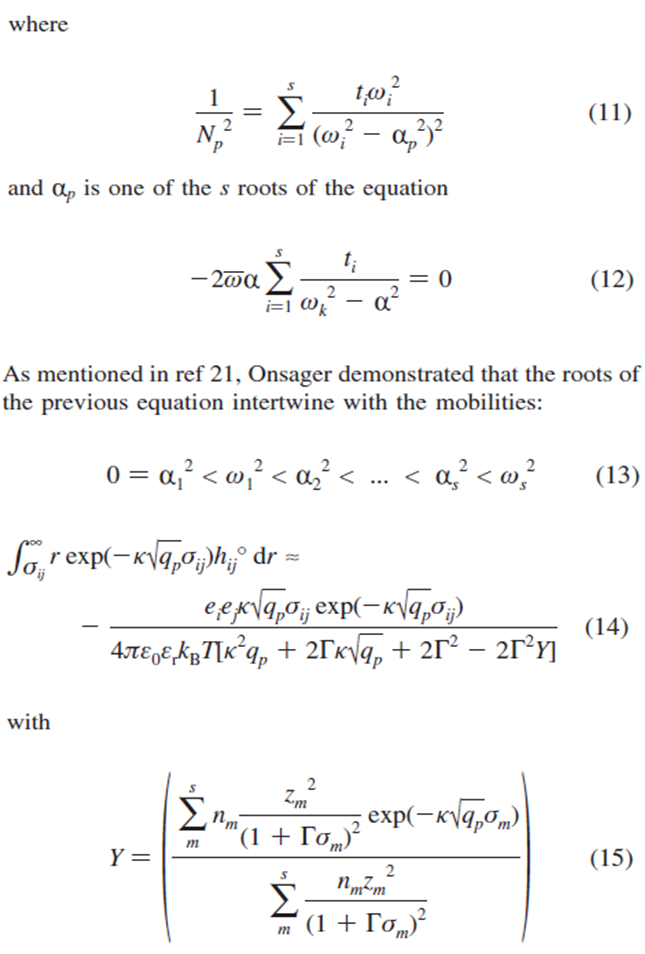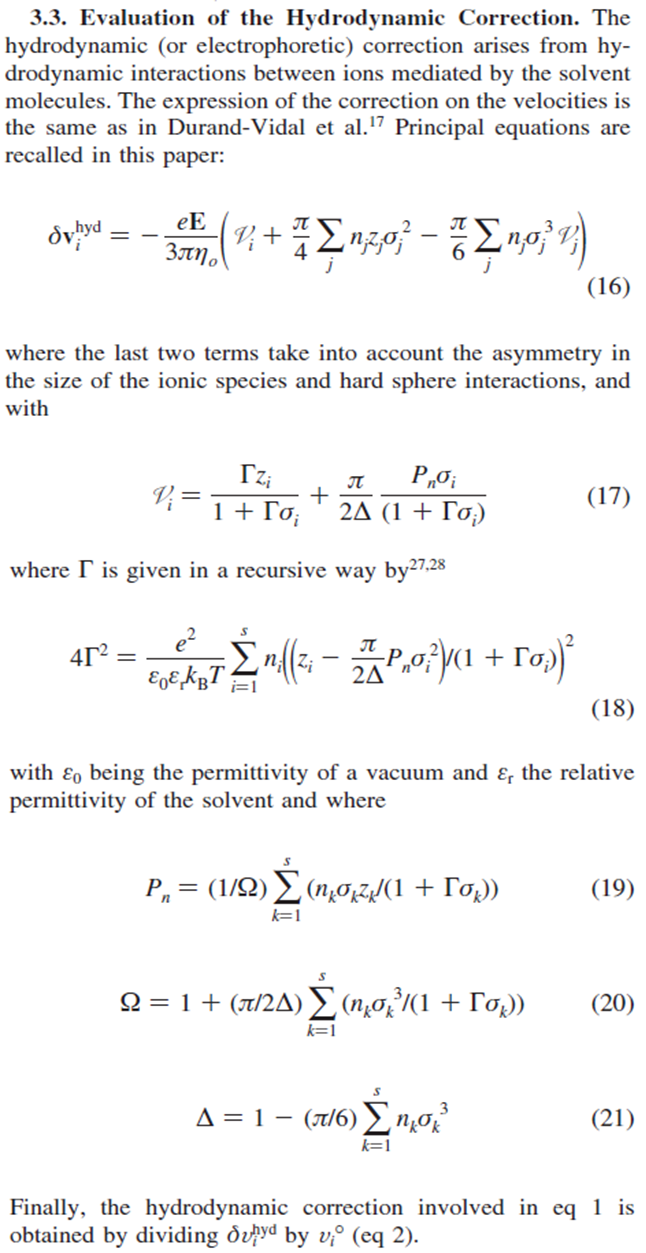

Code implementation

In [573]:
# loading experiment data
data = pd.read_csv("NaCl_CaCl2.csv")
NaCl_conc = data["NaCl conc"]
CaCl2_conc = data["CaCl2 conc"]
cond = data["Bulk cond"]

# number of data points
ndata = len(cond)

In [574]:
# equation parameters in SI units
Avogadros_num = 6.022*10**23
k_B = 1.381 * 10**(-23)
T = 298.15
charge = 1.602 * 10**(-19)
Diff_Na = 1.334 * 10**(-9)
Diff_Cl = 2.032 * 10**(-9)
Diff_Ca = 0.792 * 10**(-9)
voltage = 25 * 10**(-3)
distance = 9 * 10**(-6)
E_field = voltage/distance
z_Na = 1
z_Cl = -1
z_Ca = 2
epsilon = 78.4
epsilon_0 = 8.854 * 10**(-12)
sigma_Na = 100 * 10**(-12)
sigma_Cl = 190 * 10**(-12)
sigma_Ca = 140 * 10**(-12)
eta = 0.89 * 10**(-3)

C:\Users\lilon\AppData\Local\Temp\ipykernel_9132\645381228.py:116: RuntimeWarning: divide by zero encountered in scalar divide
  return((alpha_scaled)*sum(transport_num[k]/((omega[i]/omega_bar)**2 - (alpha_scaled)**2) for k in range(n_species)))


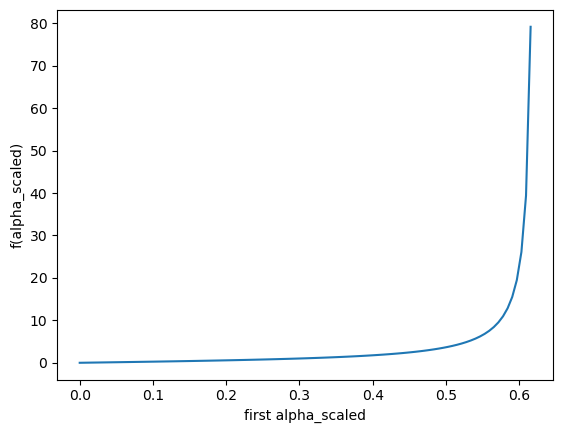

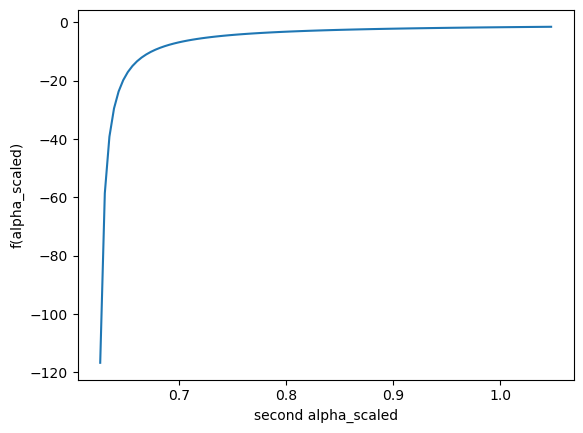

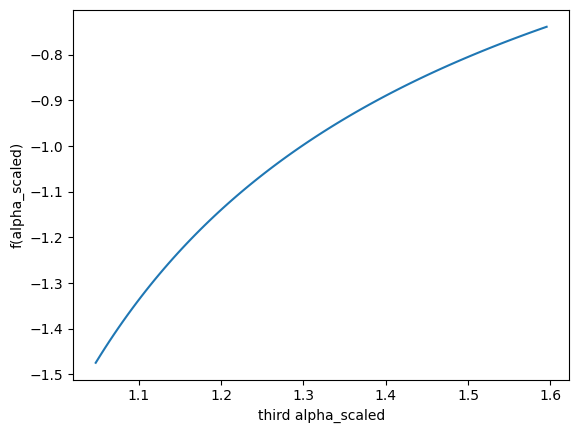

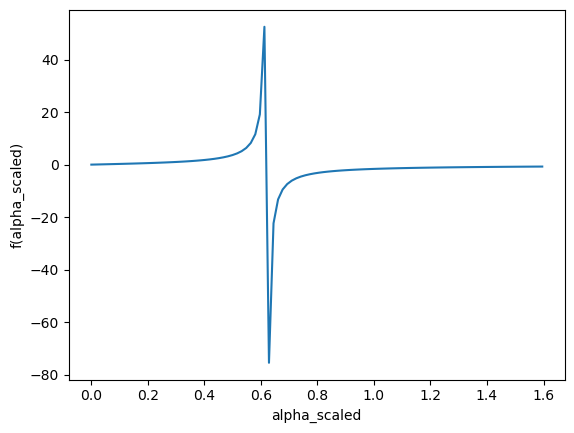

omega_bar: 309310608411.8851
Mew: [0.57142857 0.07142857 0.35714286]
Transport number: [0.35535614 0.07481772 0.56982614]
Omega: [1.92351992e+11 3.23986816e+11 4.93509152e+11]
Hydrodynamic correction: -0.12675299752429176


In [605]:
# converting molar concentrations to number density
number_density_NaCl = [NaCl_conc[i]*Avogadros_num for i in range(ndata)]
number_density_CaCl2 = [CaCl2_conc[i]*Avogadros_num for i in range(ndata)]

# components list
components = ["Ca", "Na", "Cl"]

# number of species
n_species = len(components)

# valencies
valency = [z_Ca, z_Na, z_Cl]

# species charge
ion_charge = [valency[i]*charge for i in range(len(valency))]

# diffusion coefficients
diff_coeff = [Diff_Ca, Diff_Na, Diff_Cl]

# hard sphere diameters
diameters = [sigma_Ca, sigma_Na, sigma_Cl]

# evaluating number density of individual species
number_density_Na = number_density_NaCl
number_density_Ca = number_density_CaCl2
number_density_Cl = [number_density_NaCl[i] + 2*number_density_CaCl2[i] for i in range(ndata)]

# for first mixture concentration (row) in data
for n in range(1):
    number_density = [number_density_Ca[n], number_density_Na[n], number_density_Cl[n]]

    # initial ksi matrix
    ksi_all = np.zeros((n_species, n_species))

    # initial summation term of conductivity in equation (1)
    cond_sum = 0.0

    # evaluating the summation term of the conductivity in equation (1) for only one species
    for i in range(1):
        # evaluating the velocity produced by the net electric force on species i
        vel = valency[i]*charge*E_field*diff_coeff[i]/(k_B*T)

        # evaluating delta velocity hydrodynamic
        delta = 1 - ((math.pi/6)*sum(number_density[k]*diameters[k]**3 for k in range(n_species)))
        def func_gamma(gamma):
            """
            Evaluates residual of equation (18)

            Arguments:
                gamma

            Returns:
                Residual of the equation
            """
            capital_omega = 1 + ((math.pi/(2*delta))*sum(number_density[k]*diameters[k]**3/(1 + gamma*diameters[k]) for k in range(n_species)))
            P_n = (1/capital_omega)*sum(number_density[k]*diameters[k]*valency[k]/(1 + gamma*diameters[k]) for k in range(n_species))
            return(4*gamma**2 - ((charge**2/(epsilon*epsilon_0*k_B*T))*
                   sum(number_density[l]*((valency[l] - math.pi*P_n*diameters[l]**2/(2*delta))/(1 + gamma*diameters[l]))**2 for l in range(n_species)))
                  )

        # finding gamma, the root of equation (18)
        root_func_gamma = fsolve(func_gamma, 1e16)
        gamma = root_func_gamma[0]
        capital_omega = 1 + ((math.pi/(2*delta))*sum(number_density[k]*diameters[k]**3/(1 + gamma*diameters[k]) for k in range(n_species)))
        P_n = (1/capital_omega)*sum(number_density[k]*diameters[k]*valency[k]/(1 + gamma*diameters[k]) for k in range(n_species))
        nu = gamma*valency[i]/(1 + gamma*diameters[i]) + (math.pi/(2*delta))*(P_n*diameters[i]/(1 + gamma*diameters[i]))

        # delta velocity hydrodynamic equation (16)
        delta_vel = (-charge*E_field/(3*math.pi*eta))*(nu + (math.pi/4)*sum(number_density[j]*valency[j]*diameters[j]**2 for j in range(n_species)) 
                                                           - (math.pi/6)*sum(number_density[j]*(diameters[j]**3)*nu for j in range(n_species)))

        # hydrodynamic correction equation (16) divide equation (2)
        delta_vel_divide_vel = delta_vel/vel

        # evaluating omega and mew for all species
        omega = np.zeros(n_species)
        mew = np.zeros(n_species)
        for a in range(n_species):
            omega[a] = diff_coeff[a]/(k_B*T) 
            mew[a] = number_density[a]*ion_charge[a]**2/sum(number_density[j]*ion_charge[j]**2 for j in range(n_species))
        
        # evaluating kappa
        kappa = math.sqrt(sum(number_density[l]*ion_charge[l]**2/(epsilon*epsilon_0*k_B*T) for l in range(n_species)))
        
        # evaluating omega_bar, the mean mobility
        omega_bar = sum(mew[j]*omega[j] for j in range(n_species))

        # evaluating transport number for all species
        transport_num = np.zeros(n_species)
        for j in range(n_species):
            transport_num[j] = mew[j]*omega[j]/omega_bar

        # evaluating q, N and ksi for all species
        q = np.zeros(n_species)
        N = np.zeros(n_species)
        ksi = np.zeros(n_species)
        # alphas = np.zeros(n_species)
        # def func_alpha(alpha):
        #     return(-2*omega_bar*alpha*sum(transport_num[k]/(omega[i]**2 - alpha**2) for k in range(n_species)))
        # alphas = [1e11, 1e11, 1e11]
        # for p in range(len(alphas)):
        #     root2 = fsolve(func_alpha, alphas[p])
        #     alphas[p] = root2[0]
        # def func_alpha(alpha_sq):
        #     return(alpha_sq*sum(transport_num[k]/(omega[i]**2 - alpha_sq) for k in range(n_species)))
        def func_alpha(alpha_scaled):
            """ 
            Evaluates residuals of equation 12

            Arguments:
                alpha_scaled = alpha/omega_bar

            Returns:
                residual of the equation
            """
            return((alpha_scaled)*sum(transport_num[k]/((omega[i]/omega_bar)**2 - (alpha_scaled)**2) for k in range(n_species)))
        
        # since alpha is scaled by omega_bar, the bounds (omega), need to be scaled by same factor
        omega_scaled = np.zeros(n_species)
        for k in range(n_species):
            if k == 0:
                omega_scaled[k] = omega[k]/omega_bar
            elif k == 1:
                omega_scaled[k] = omega[k]/omega_bar
            else:
                omega_scaled[k] = omega[k]/omega_bar

        # plotting the bounds of alpha for each species
        for k in range(n_species):
            if k == 0:
                alpha_scaled_range = np.linspace(0, omega_scaled[k], 100)
                f_vals = []
                for p in alpha_scaled_range:
                    val = func_alpha(p)
                    f_vals.append(val)
                plt.plot(alpha_scaled_range, f_vals)
                plt.xlabel("first alpha_scaled")
                plt.ylabel("f(alpha_scaled)")
                plt.show()
            elif k == 1:
                alpha_scaled_range = np.linspace(omega_scaled[k-1], omega_scaled[k], 100)
                f_vals = []
                for p in alpha_scaled_range:
                    val = func_alpha(p)
                    f_vals.append(val)
                plt.plot(alpha_scaled_range, f_vals)
                plt.xlabel("second alpha_scaled")
                plt.ylabel("f(alpha_scaled)")
                plt.show()
            else:
                alpha_scaled_range = np.linspace(omega_scaled[k-1], omega_scaled[k], 100)
                f_vals = []
                for p in alpha_scaled_range:
                    val = func_alpha(p)
                    f_vals.append(val)
                plt.plot(alpha_scaled_range, f_vals)
                plt.xlabel("third alpha_scaled")
                plt.ylabel("f(alpha_scaled)")
                plt.show()
        
        # plotting the overall bounds of all alphas
        alpha_scaled_range = np.linspace(0, omega_scaled[n_species-1], 100)
        f_vals = []
        for p in alpha_scaled_range:
            val = func_alpha(p)
            f_vals.append(val)
        plt.plot(alpha_scaled_range, f_vals)
        plt.xlabel("alpha_scaled")
        plt.ylabel("f(alpha_scaled)")
        plt.show()
        
        # for p in range(n_species):
        #     if p == 0:
        #         alphas_sq[p] = bisect(func_alpha, 0, 0.9*omega[p]**2)
        #     elif p == 1:
        #         alphas_sq[p] = bisect(func_alpha, 1.1*omega[p-1]**2, 0.9*omega[p]**2)
        #     else:
        #         alphas_sq[p] = bisect(func_alpha, 1.1*omega[p-1]**2, 0.9*omega[p]**2)
    #     alphas = np.zeros(n_species)
    #     for p in range(n_species):
    #         q[p] = sum(omega_bar*transport_num[r]/(omega[r] + alphas[p]) for r in range(n_species))
    #         N[p] = math.sqrt(1/sum(transport_num[r]*omega[r]**2/(omega[r]**2 - alphas[p]**2)**2 for r in range(n_species)))
    #         ksi[p] = N[p]*omega[i]/(omega[i]**2 - alphas[p]**2)
    #     ksi_all[i] = ksi

    #     # evaluating summation term for relaxation correction in equation (4)
    #     delta_k_divide_k_sum = 0.0
    #     for p in range(n_species):
    #         for j in range(n_species):
    #             for a in range(n_species):
    #                 sigma_aj = 0.5*(diameters[a] + diameters[j])
    #                 term1 = transport_num[j]*ksi_all[j][p]*mew[a]*(ion_charge[a]*omega[a] - ion_charge[j]*omega[j])/(ion_charge[a]*ion_charge[j]*(omega[a] + omega[j]))
    #                 term2 = math.sinh(kappa*math.sqrt(q[p])*sigma_aj)/(kappa*math.sqrt(q[p])*sigma_aj)
    #                 integral_num = -ion_charge[a]*ion_charge[j]*kappa*math.sqrt(q[p])*sigma_aj*np.exp(-kappa*math.sqrt(q[p])*sigma_aj)
    #                 Y_num = sum(number_density[m]*(valency[m]**2)*np.exp(-kappa*math.sqrt(q[p])*diameters[m])/(1 + gamma*diameters[m])**2 for m in range(n_species))
    #                 Y_denom = sum(number_density[m]*valency[m]**2/(1 + gamma*diameters[m])**2 for m in range(n_species))
    #                 Y = Y_num/Y_denom
    #                 integral_denom = 4*math.pi*epsilon_0*epsilon*k_B*T*((kappa**2)*q[p] + 2*gamma*kappa*math.sqrt(q[p]) + 2*gamma**2 - 2*(gamma**2)*Y)
    #                 delta_k_divide_k_sum += ksi_all[i][p]*term1*term2*(integral_num/integral_denom)
        
    #     # relaxation correction from equation (4)
    #     delta_k_divide_k = -(kappa**2)*ion_charge[i]*delta_k_divide_k_sum/3
    #     cond_sum += number_density[i]*diff_coeff[i]*(valency[i]**2)*(1 + delta_vel_divide_vel)*(1 + delta_k_divide_k)
    # cond = (charge**2)*cond_sum/(k_B*T)

# print(f"Cond (S/m): {cond}")
# print(f"Gamma: {gamma}")
# print(f"f(gamma): {func_gamma(gamma)}")
print(f"omega_bar: {omega_bar}")
# print(f"Alpha: {alphas}")
print(f"Mew: {mew}")
print(f"Transport number: {transport_num}")
print(f"Omega: {omega}")
# print(f"Relaxation correction: {delta_k_divide_k_act}")
print(f"Hydrodynamic correction: {delta_vel_divide_vel}")